# IMDA Dataset processing

In [1]:
import os
import re
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter(action='ignore')

## load results

In [3]:
session1_df = pd.read_csv("../data/session1/IMDA_session1_merged_rule_n_GPT4o.csv")
session1_df.head()

,file_name,session_id,speaker_id,speaker_type,dialog_type,x_min,x_max,text,cleaned_text_for_sentiment,word_count,...,max_agreement_votes,others_agree_with_each_other,vader_avg,textblob_avg,stanza_avg,rule_based_score,GPT4o_label,others_agree_with_LLM,final_sentiment_score,final_sentiment_label
0,app_0001_3002_phnd_cc-hol.TextGrid,1.0,3002.0,client,holiday,18.58958,23.42000,one of the adult is wheelchair bound which is ...,one of the adult is wheelchair bound which is ...,13.0,...,9,True,0.0000,0.100000,0.0,0.033333,negative,False,-0.113333,negative
1,app_0001_3002_phnd_cc-hol.TextGrid,1.0,3002.0,client,holiday,25.79000,32.49143,my spouse and myself and my two children and (...,my spouse and myself and my two children and (...,11.0,...,9,True,0.3612,0.000000,0.0,0.120400,neutral,True,0.036120,neutral
2,app_0001_3002_phnd_cc-hol.TextGrid,1.0,3002.0,client,holiday,32.49143,41.16000,first for the air airplane right I would like ...,first for the air airplane right I would like ...,16.0,...,5,False,0.3612,0.058929,-0.8,-0.126624,neutral,True,0.150000,neutral
3,app_0001_3002_phnd_cc-hol.TextGrid,1.0,3002.0,client,holiday,41.16000,46.47164,to the toilet so it's more convenient for my (...,to the toilet so it s more convenient for my (...,9.0,...,5,False,0.0000,0.100000,-1.0,-0.300000,neutral,False,0.300000,neutral
4,app_0001_3002_phnd_cc-hol.TextGrid,1.0,3002.0,client,holiday,46.47164,57.26000,parent and also my kids because you know the t...,parent and also my kids because you know the t...,16.0,...,9,True,0.0000,0.000000,0.0,0.000000,neutral,True,0.210000,neutral


In [5]:
session2_df = pd.read_csv("../data/IMDA_session2_merged_rule_n_GPT4o.csv")
session2_df.columns

Index(['file_name', 'x_min', 'GPT4o', 'explanation', 'session_id',
       'speaker_id', 'speaker_type', 'dialog_type', 'x_max', 'text',
       'cleaned_text_for_sentiment', 'word_count', 'duration',
       'qualified_for_sentiment', 'processed_text', 'sum_score',
       'rule_based_label', 'max_agreement_votes',
       'others_agree_with_each_other', 'vader_avg', 'textblob_avg',
       'stanza_avg', 'rule_based_score', 'GPT4o_label',
       'others_agree_with_LLM', 'final_sentiment_score',
       'final_sentiment_label'],
      dtype='object')

In [6]:
session3_df = pd.read_csv("../data/session3/IMDA_session3_merged_rule_n_GPT4o.csv")
session3_df.columns

Index(['file_name', 'session_id', 'speaker_id', 'speaker_type', 'dialog_type',
       'x_min', 'x_max', 'text', 'cleaned_text_for_sentiment', 'word_count',
       'duration', 'qualified_for_sentiment', 'GPT4o', 'explanation',
       'sum_score', 'rule_based_label', 'max_agreement_votes',
       'others_agree_with_each_other', 'vader_avg', 'textblob_avg',
       'stanza_avg', 'rule_based_score', 'GPT4o_label',
       'others_agree_with_LLM', 'final_sentiment_score',
       'final_sentiment_label'],
      dtype='object')

In [8]:
print(session1_df.shape)
print(session2_df.shape)
print(session3_df.shape)

(137713, 26)
(84495, 27)
(79729, 26)


In [9]:
dataset_df = pd.concat([session1_df,session2_df,session3_df])
dataset_df = dataset_df.drop(columns=['processed_text'])
dataset_df.final_sentiment_label.value_counts()

final_sentiment_label
neutral     173469
positive     92155
negative     36313
Name: count, dtype: int64

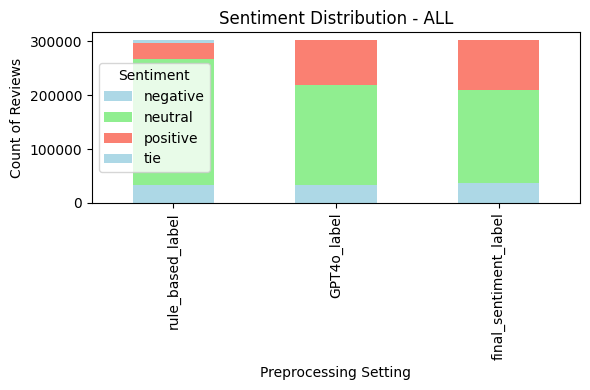

In [12]:
import matplotlib.pyplot as plt
# Calculate the sentiment distribution for each method
distribution = dataset_df[['rule_based_label', 'GPT4o_label','final_sentiment_label']].apply(pd.Series.value_counts)

# Plot the sentiment distribution for VADER
distribution.T.plot(kind='bar', stacked=True, figsize=(6,4), color=['lightblue', 'lightgreen', 'salmon'])
plt.title('Sentiment Distribution - ALL')
plt.xlabel('Preprocessing Setting')
plt.ylabel('Count of Reviews')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


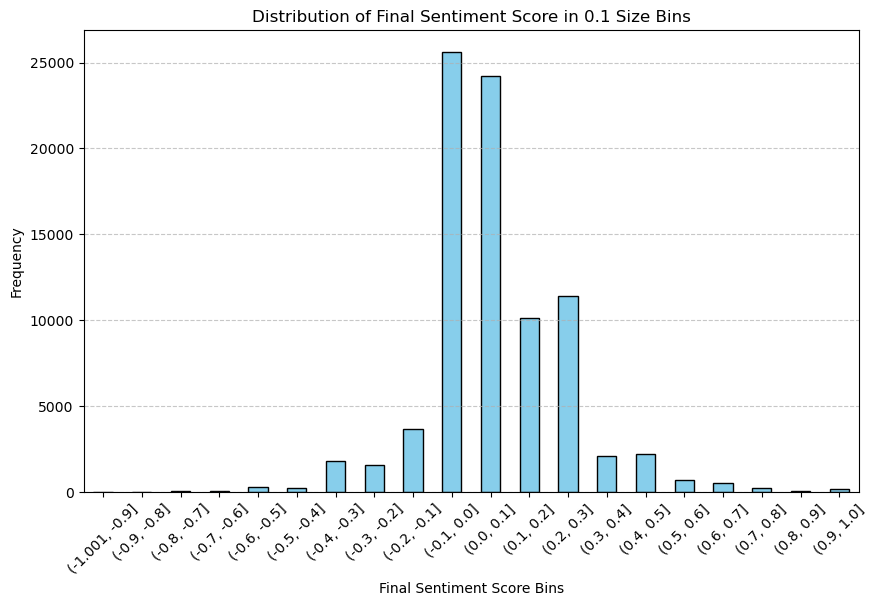

final_sentiment_score
(-1.001, -0.9]        5
(-0.9, -0.8]          1
(-0.8, -0.7]         63
(-0.7, -0.6]         49
(-0.6, -0.5]        321
(-0.5, -0.4]        236
(-0.4, -0.3]       1828
(-0.3, -0.2]       1596
(-0.2, -0.1]       3646
(-0.1, 0.0]       25608
(0.0, 0.1]        24214
(0.1, 0.2]        10129
(0.2, 0.3]        11411
(0.3, 0.4]         2092
(0.4, 0.5]         2246
(0.5, 0.6]          693
(0.6, 0.7]          544
(0.7, 0.8]          213
(0.8, 0.9]           76
(0.9, 1.0]          205
Name: count, dtype: int64


In [16]:
import matplotlib.pyplot as plt

# Calculate binning of 'final_sentiment_score' in bins of size 0.1
bin_counts = pd.cut(merged_df['final_sentiment_score'], bins=[i/10 for i in range(-10, 11)], include_lowest=True).value_counts().sort_index()

# Plotting the distribution
plt.figure(figsize=(10, 6))
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Final Sentiment Score in 0.1 Size Bins')
plt.xlabel('Final Sentiment Score Bins')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Display the bin counts
print(bin_counts)

### train test split

In [15]:
# take first around 120 session id as test set 
testset_df =  dataset_df[ (dataset_df.session_id>=683) & (dataset_df.session_id<=800)]
trainset_df = dataset_df[~((dataset_df.session_id >= 683) & (dataset_df.session_id <= 800))]

trainset_df = trainset_df.reset_index(drop=True)

testset_df['final_sentiment_label'].value_counts(), trainset_df['final_sentiment_label'].value_counts()

(final_sentiment_label
 neutral     10372
 positive     3524
 negative     2093
 Name: count, dtype: int64,
 final_sentiment_label
 neutral     163097
 positive     88631
 negative     34220
 Name: count, dtype: int64)

In [18]:
dataset_df[[ 'session_id','x_min', 'speaker_id', 'speaker_type', 'dialog_type',
       'cleaned_text_for_sentiment', 'word_count', 'rule_based_label', 
       'others_agree_with_each_other', 'vader_avg', 'textblob_avg',
       'stanza_avg', 'rule_based_score', 'GPT4o', 'GPT4o_label',
       'others_agree_with_LLM', 'final_sentiment_score',
       'final_sentiment_label']].to_csv("../data/IMDA_all_for_text_sentiment.csv",index=False)

# The END